In [1]:
import os
import sys
from sklearn.metrics import confusion_matrix

sys.path.append("../src")
from ridge_regression import *
from setup_problem import *
from shooting_algo import shooting_algo, lasso_regularization_path
from projected_sgd_lasso import projected_sgd_lasso, projected_batch_grad_desc_lasso


# Problem 2 Ridge Regression

### Problem 2.1

In [2]:
lasso_fname = os.path.join('..','src','lasso_data.pickle')

x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_fname)

In [3]:
x_train_feat = featurize(x_train)
x_val_feat = featurize(x_val)

In [ ]:
grid, df = do_grid_search_ridge(x_train_feat, y_train, x_val_feat, y_val)

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(10,10));

plt.semilogx(df.param_l2reg, df.mean_train_score, label='Train');
plt.semilogx(df.param_l2reg, df.mean_test_score, label='Validation');

min_index = df.mean_test_score.idxmin()
arg_min_lambda = df.param_l2reg[min_index]
min_test_score = df.mean_test_score[min_index]
plt.plot(arg_min_lambda, min_test_score, 'k*', label='Minimum Validation Error')

plt.title('Loss vs Regularization Param', fontsize=14);
plt.xlabel(r'$\lambda$', fontsize=14);
plt.ylabel('Mean Square Error');
plt.grid(b=True, which='major');
plt.grid(b=True, which='minor', linestyle='--');
plt.legend();

plt.ylim([0,0.4]);

### Problem 2.2

In [ ]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.0001), x_train]))
X = featurize(x)

name = 'Target Parameter Values (i.e. Bayes Optimal)'
pred_fns.append({'name':name, 'coefs':coefs_true, 'preds': target_fn(x) })

name = 'Ridge with L2Reg=0'
ridge_regression_estimator = RidgeRegression(l2reg=0)
ridge_regression_estimator.fit(x_train_feat, y_train)
pred_fns.append({'name':name,'coefs':ridge_regression_estimator.w_, 
                 'preds': ridge_regression_estimator.predict(X) })

name = 'Ridge with L2Reg={0:.4}'.format(arg_min_lambda)
ridge_regression_estimator = RidgeRegression(l2reg=arg_min_lambda)
ridge_regression_estimator.fit(x_train_feat, y_train)
pred_fns.append({'name':name,'coefs':ridge_regression_estimator.w_, 
                 'preds': ridge_regression_estimator.predict(X)})

In [ ]:
plt.figure(figsize=(10,10));
plt.scatter(x_train, y_train, label='Training data');

for i in range(len(pred_fns)):
    plt.plot(x, pred_fns[i]['preds'], label=pred_fns[i]['name']);
    
plt.legend();
plt.xlabel(r'$\lambda$', fontsize=14);
plt.ylabel('Mean Square Error');
plt.grid(b=True, which='major');
plt.grid(b=True, which='minor', linestyle='--');

In [ ]:
compare_parameter_vectors(pred_fns)

### Problem 2.3

In [ ]:
ridge_regression_estimator = RidgeRegression(l2reg=arg_min_lambda)
ridge_regression_estimator.fit(x_train_feat, y_train)
best_coefs = ridge_regression_estimator.w_

In [ ]:
y_true = coefs_true.copy()
y_true[np.abs(y_true) > 1e-6] = 1

In [ ]:
y_1 = best_coefs.copy()
y_1[np.abs(y_1) > 1e-6] = 1
y_1[np.abs(y_1) <= 1e-6] = 0

y_2 = best_coefs.copy()
y_2[np.abs(y_2) > 1e-3] = 1
y_2[np.abs(y_2) <= 1e-3] = 0

y_3 = best_coefs.copy()
y_3[np.abs(y_3) > 1e-1] = 1
y_3[np.abs(y_3) <= 1e-1] = 0


In [ ]:
confusion_matrix(y_true, y_1)

In [ ]:
confusion_matrix(y_true, y_2)

In [ ]:
confusion_matrix(y_true, y_3)

# Problem 3 Coordinate Descent for LASSO

### Problem 3.1 Shooting Algo

In the shooting algo we need to compute the following parameters for each feature $j$
$$\begin{align*}
a_j &= 2\sum_{i=1}^n x_{ij}^2\\
c_j &= 2 \sum_{i=1}^n x_{ij}(y_i-w^Tx_i + w_{j}x_{ij})
\end{align*}
$$

The steps can be vectorized to 
$$
\begin{align*}
a_j &= 2\cdot ||X_{\ \cdot\ j}||^2\\
c_j &= 2\cdot \left(X_{\ \cdot\ j}^T(y - Xw)+ w_j\cdot ||X_{\ \cdot\ j}||^2\right)\\
\end{align*}
$$

In [4]:
n, d = x_train_feat.shape

In [5]:
theta_hist_rand, loss_hist_rand = shooting_algo(x_train_feat, y_train, lambda_reg=10, method='rand')
theta_hist_rand_cyclic, loss_hist_cyclic = shooting_algo(x_train_feat, y_train,lambda_reg=10, method='cyclic')


../src/shooting_algo.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(A, b)[0].squeeze()


In [11]:
theta_hist_zero_init, loss_hist_zero_init= shooting_algo(x_train_feat, y_train, lambda_reg=10, theta=np.zeros(d), method='rand')


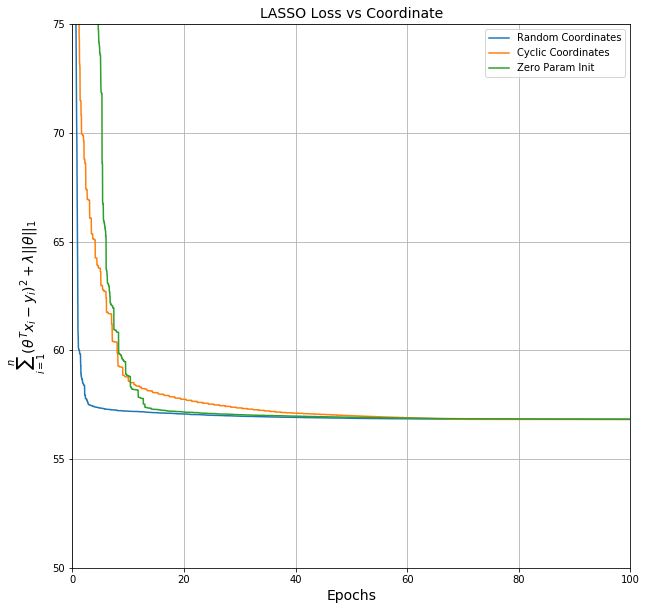

In [17]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(loss_hist_rand.size)/d, loss_hist_rand.ravel(), label='Random Coordinates')
plt.plot(np.arange(loss_hist_cyclic.size)/d, loss_hist_cyclic.ravel(), label='Cyclic Coordinates')
plt.plot(np.arange(loss_hist_zero_init.size)/d, loss_hist_zero_init.ravel(), label='Zero Param Init')

plt.title('LASSO Loss vs Coordinate', fontsize=14);
plt.xlabel('Epochs', fontsize=14);
plt.ylabel(r'$\sum_{i=1}^n (\theta^Tx_i - y_i)^2 + \lambda ||\theta||_1$', fontsize=14);
plt.grid(b=True, which='major');
plt.grid(b=True, which='minor', linestyle='--');
plt.xlim([0, 100])
plt.ylim([50, 75])
plt.legend();

The above graph shows that making random passes over the coordinates benefits convergence when compared to simply cycling over the coordinates in the order presented. It also shows that warm starting at the Tychanov regularized solution is beneficial as opposed to an initialization of the parameters to all zeros.

In [4]:
lambdas, loss = lasso_regularization_path(x_train_feat, y_train, x_val_feat, y_val, lambdas=10**np.linspace(-3,0,50), max_iter=1000)


../src/shooting_algo.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(A, b)[0].squeeze()


Iter: 0  Loss:(143, 400)
Iter: 1  Loss:(154, 400)
Iter: 2  Loss:(169, 400)
Iter: 3  Loss:(187, 400)
Iter: 4  Loss:(202, 400)
Iter: 5  Loss:(226, 400)
Iter: 6  Loss:(242, 400)
Iter: 7  Loss:(270, 400)
Iter: 8  Loss:(292, 400)
Iter: 9  Loss:(321, 400)
Iter: 10  Loss:(346, 400)
Iter: 11  Loss:(379, 400)
Iter: 12  Loss:(397, 400)
Iter: 13  Loss:(438, 400)
Iter: 14  Loss:(463, 400)
Iter: 15  Loss:(495, 400)
Iter: 16  Loss:(532, 400)
Iter: 17  Loss:(561, 400)
Iter: 18  Loss:(606, 400)
Iter: 19  Loss:(638, 400)
Iter: 20  Loss:(684, 400)
Iter: 21  Loss:(719, 400)
Iter: 22  Loss:(769, 400)
Iter: 23  Loss:(790, 400)
Iter: 24  Loss:(837, 400)
Iter: 25  Loss:(872, 400)
Iter: 26  Loss:(919, 400)
Iter: 27  Loss:(955, 400)
Iter: 28  Loss:(996, 400)
Iter: 29  Loss:(1000, 400)
Iter: 30  Loss:(1000, 400)
Iter: 31  Loss:(1000, 400)
Iter: 32  Loss:(1000, 400)
Iter: 33  Loss:(936, 400)
Iter: 34  Loss:(953, 400)
Iter: 35  Loss:(960, 400)
Iter: 36  Loss:(985, 400)
Iter: 37  Loss:(1000, 400)
Iter: 38  Loss:(8

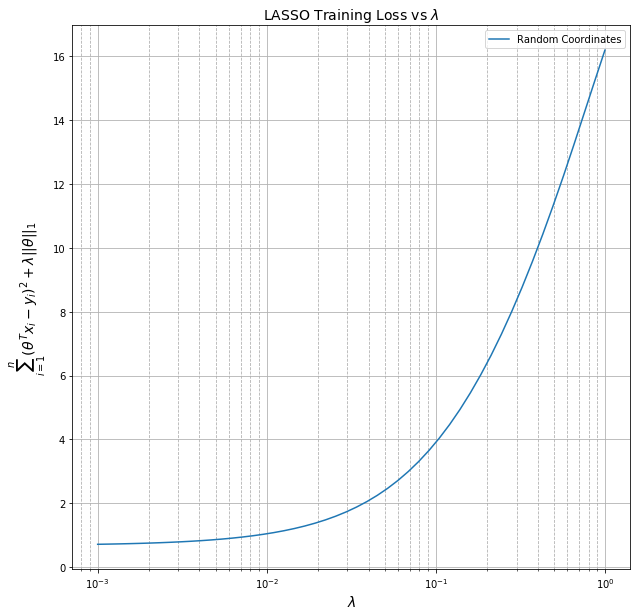

In [6]:
plt.figure(figsize=(10,10))
plt.semilogx(lambdas, loss, label='Random Coordinates')

plt.title(r'LASSO Training Loss vs $\lambda$', fontsize=14);
plt.xlabel(r'$\lambda$', fontsize=14);
plt.ylabel(r'$\sum_{i=1}^n (\theta^Tx_i - y_i)^2 + \lambda ||\theta||_1$', fontsize=14);
plt.grid(b=True, which='major');
plt.grid(b=True, which='minor', linestyle='--');
# plt.xlim([0, 100])
# plt.ylim([50, 75])
plt.legend();

### Problem 3.2 Coordinate Minimizer Derivation

Define the lasso objective with respect to a single component of the parameter vector as
$$\begin{align*}
f(w_j) &= \sum_{i=1}^n (w^Tx_i - y_i)^2 + \lambda ||w||_1\\
&= \sum_{i=1}^n \left[w_j x_{ij} + \sum_{k\ne j}w_k x_{ik} - y_i\right]^2 + \lambda |w_j| +\lambda\sum_{k\ne j}|w_k|\\
\end{align*}
$$

If $x_{ij} = 0 $ for all $i=1,\ldots,n$ then the objective reduces to

$$f(w_j) = \sum_{i=1}^n \left[\sum_{k\ne j}w_k x_{ik} - y_i\right]^2 + \lambda |w_j| +\lambda\sum_{k\ne j}|w_k|$$
which is trivially minimized by $w^\star_j = 0$ since the only term dependent on the input is $\lambda |w_j|$.

When $w_j \ne 0$ then $f(w_j)$ is differentiable wrt $w_j$ with derivative

$$\begin{align*}
\frac{\mathrm{d}f(w_j)}{\mathrm{d}w_j} &= 2\sum_{i=1}^n (w^Tx_i - y_i)x_{ij} + \lambda\cdot\mathbf{sign}(w_j)\\
&= 2\sum_{i=1}^n \left(w_j x_{ij} + \sum_{k\ne j}w_k x_{ik} - y_i\right)x_{ij} + \lambda\cdot\mathbf{sign}(w_j)\\
&= 2\sum_{i=1}^n w_j x^2_{ij} + 2\sum_{i=1}^n\left(\sum_{k\ne j}w_k x_{ik} - y_i\right)x_{ij} + \lambda
\cdot\mathbf{sign}(w_j)\\
&= w_j a_j  - c_j+ \lambda\cdot\mathbf{sign}(w_j)
\end{align*}
$$

If $w_j > 0$ we can set the derivative to zero and find the optimum
$$
\begin{align*}
w^{\star}_ja_j - c_j + \lambda &= 0\\
w^{\star}_j &= \frac{c_j - \lambda}{a_j}
\end{align*}
$$
Similarly if $w_j < 0$ we can set the derivative to zero
$$
\begin{align*}
w^{\star}_ja_j - c_j - \lambda &= 0\\
w^{\star}_j &= \frac{c_j + \lambda}{a_j}
\end{align*}
$$

A minimizer of the objective will have the directional derivative which is nonnegative in all directions. Since this problem is one dimensional, we only have to check the directional derivative from left and right of 0

$$
\begin{align*}
f_{right}'(0) &= \lim_{\epsilon \rightarrow 0^+} \frac{\sum_{i=1}^n \left(\epsilon x_{ij} + \sum_{k\ne j}w_kx_{ik} - y_i\right)^2 + \lambda \epsilon + \sum_{k\ne j}|w_k| -\left(\sum_{i=1}^n \left(\sum_{k\ne j}w_kx_{ik}-y_i\right)^2+ \sum_{k\ne j}|w_k|\right)} {\epsilon} \\
&= \lim_{\epsilon \rightarrow 0^+} \frac{\sum_{i=1}^n \epsilon^2 x_{ij}^2 + 2\sum_{i=1}^n\epsilon x_{ij}\left(\sum_{k\ne j}w_kx_{ik} - y_i\right)+\sum_{i=1}^n \left(\sum_{k\ne j}w_kx_{ik} - y_i\right)^2+\lambda \epsilon + \sum_{k\ne j}|w_k| -\left(\sum_{i=1}^n \left(\sum_{k\ne j}w_kx_{ik}-y_i\right)^2+ \sum_{k\ne j}|w_k|\right)} {\epsilon} \\
&= \lim_{\epsilon \rightarrow 0^+} \frac{\epsilon^2 a_j -\epsilon c_j+\lambda \epsilon} {\epsilon} \\
&= -c_j + \lambda\\
\end{align*}
$$

Performing the calculations approaching 0 from below we have 

$$
\begin{align*}
f_{left}'(0) &= \lim_{\epsilon \rightarrow 0^-} \frac{\sum_{i=1}^n \left(\epsilon x_{ij} + \sum_{k\ne j}w_kx_{ik} - y_i\right)^2 - \lambda \epsilon + \sum_{k\ne j}|w_k| -\left(\sum_{i=1}^n \left(\sum_{k\ne j}w_kx_{ik}-y_i\right)^2+ \sum_{k\ne j}|w_k|\right)} {\epsilon} \\
&= \lim_{\epsilon \rightarrow 0^-} \frac{\sum_{i=1}^n \epsilon^2 x_{ij}^2 + 2\sum_{i=1}^n\epsilon x_{ij}\left(\sum_{k\ne j}w_kx_{ik} - y_i\right)+\sum_{i=1}^n \left(\sum_{k\ne j}w_kx_{ik} - y_i\right)^2-\lambda \epsilon + \sum_{k\ne j}|w_k| -\left(\sum_{i=1}^n \left(\sum_{k\ne j}w_kx_{ik}-y_i\right)^2+ \sum_{k\ne j}|w_k|\right)} {\epsilon} \\
&= \lim_{\epsilon \rightarrow 0^-} \frac{\epsilon^2 a_j -\epsilon c_j-\lambda \epsilon} {\epsilon} \\
&= -c_j - \lambda\\
\end{align*}
$$

To ensure the directional deriviate is nonnegative at 0 we must have
$$\begin{align*}
-c_j - \lambda &\le 0\\
-c_j + \lambda &\ge 0\\
\implies -\lambda  \le &\ c_j\le \lambda 
\end{align*}
$$

Combining the three results we have that the optimal value $w^\star_j$ is given by 

$$w^\star_j= \begin{cases} 
      \frac{1}{a_j}(c_j-\lambda)  & c_j > \lambda \\
      0 & -\lambda \le c_j \le \lambda \\
      \frac{1}{a_j}(c_j+\lambda)  &  c_j < -\lambda \\
   \end{cases}
$$

# Problem 4 LASSO Properties

The objective for LASSO problem without a bias term is 
$$J(w) = ||Xw - y||^2_2 + \lambda ||w||_1$$

### Problem 4.1 Deriving $\lambda_{max}$

The directional derivative in a direction $v$ at point $x$ is defined as 
$$ D_vf(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x+\epsilon v) - f(x)}{\epsilon}$$

We want to find how large $\lambda$ should be to guarantee that all parameters are set to 0. To start, we compute the directional derivative at 0 of the lasso objective as $\epsilon$ approaches 0 from the right 

$$
\begin{align*}
D_vJ(0) &= \lim_{\epsilon \rightarrow 0^+} \frac{J(\epsilon v) - J(0)}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \frac{||\epsilon Xv -y||^2+ \lambda||\epsilon v||_1 - ||-y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+}\frac{\epsilon^2 ||Xv||^2 + ||y||^2 - 2\epsilon y^TXv+ \epsilon\lambda|| v||_1 - ||y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \epsilon ||Xv||^2  - 2y^TXv+ \lambda || v||_1\\
&= - 2y^TXv+ \lambda || v||_1\\
\end{align*}
$$

Since the LASSO objective is convex, we are guaranteed to be at a minimum if and only if the directional derivative is nonnegative for all directions $v$. Specifically, it means the function is increasing (or at least not decreasing) everywhere when we are at a minimum. 

Setting this inequality we find a condition on $\lambda$ guaranteeing a minimum

$$\begin{align*}
D_vJ(0) &\ge 0\\
-2y^TXv + \lambda||v||_1 &\ge 0\\
\lambda &\ge \frac{2y^TXv}{||v||_1}
\end{align*}
$$

The above choice of $\lambda$ is dependent on the direction $v$. To ensure the condition holds for any direction $v$ we solve the optimization problem 

$$\text{maximize}_v\quad \frac{2y^TXv}{||v||_1}$$
Writing out the objective we have the equivalent problem 
$$\text{maximize}_v\quad \sum_{i=1}^n \alpha_i \cdot \frac{v_i}{\sum_{j=1}^n |v_j|}$$

where $\alpha = 2X^Ty$. The solution of this optimization is $v^{\star} = \mathbf{sign}(v_k) \cdot e_k$ where $k = \arg \max_i |v_i|$ which achieves an optimal objective value of $||\alpha||_\infty$. Suppose we were to choose a vector different from $v^\star$, then we can always increase the objective by moving weight from any nonzero component $v_j$ to $v_k$.

So we find that choosing regularization strength $\lambda \ge 2||X^Ty||_\infty$ in the LASSO objective will always result in $w^\star = 0$

Now suppose we include the bias term so the objective is 
$$J (w, b) = ||Xw +b \mathbf{1} - y||^2 + \lambda ||w||_1$$

We proceed similar to the case without a bias term by finding the directional derivative and then a condition on $\lambda$ ensuring $w^\star =0$ and $b^\star = \bar{y}$.

$$
\begin{align*}
D_{[v^T, u]^T}J(0,\bar{y}) &= \lim_{\epsilon \rightarrow 0^+} \frac{J(\epsilon v, \bar{y}+\epsilon u) - J(0,\bar{y})}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \frac{||\epsilon Xv + (\bar{y}+\epsilon u) \mathbf{1}-y||^2+ \lambda||\epsilon v||_1 - ||\bar{y}\mathbf{1}-y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \frac{||(\epsilon Xv +\epsilon u \mathbf{1}) + (\bar{y}\mathbf{1}-y)||^2+ \lambda||\epsilon v||_1 - ||\bar{y}\mathbf{1}-y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+}\frac{||\epsilon Xv +  \epsilon u \mathbf{1}||^2  + ||\bar{y}\mathbf{1}-y||^2+2 (\bar{y}\mathbf{1}-y)^T(\epsilon Xv + \epsilon u \mathbf{1})+ \epsilon\lambda|| v||_1 - ||\bar{y}\mathbf{1}-y||^2}{\epsilon}\\
&= \lim_{\epsilon \rightarrow 0^+} \epsilon || Xv + u \mathbf{1}||^2 + 2(\bar{y}\mathbf{1}-y)^T( Xv + u \mathbf{1})+ \lambda || v||_1\\
&= 2(\bar{y}\mathbf{1}-y)^T( Xv + u \mathbf{1})+ \lambda || v||_1\\
\end{align*}
$$

Setting the directional derivative to be greater or equal to 0 we find
$$\begin{align*}
\lambda &\ge 2\cdot \frac{(y-\bar{y}\mathbf{1})^T( Xv + u \mathbf{1})}{||v||_1}\\
&=2\cdot \frac{(y-\bar{y}\mathbf{1})^TXv + u (y-\bar{y}\mathbf{1})^T\mathbf{1}}{||v||_1}\\
&=2\cdot \frac{(y-\bar{y}\mathbf{1})^TXv}{||v||_1}
\end{align*}
$$
where the last line comes from $(y-\bar{y}\mathbf{1})^T\mathbf{1} = y^T\mathbf{1} - \bar{y}n = 0$. To ensure $\lambda$ is large enough in all directions $[v,u]$ we maximize $2\cdot \frac{(y-\bar{y}\mathbf{1})^TXv}{||v||_1}$ which from the previous problem we know is 
$$\lambda_{max} = 2||X^T(y-\bar{y})||_\infty$$

### Problem 4.2 Feature Correlation

Assume the first two columns are repeated features and partition the data an features as

$$X = \begin{bmatrix}
x_1 & x_2 & X_r
\end{bmatrix}\quad 
\theta = [\theta_1\ \theta_2\ \theta_r^T]^T
$$

The LASSO objective at the optimum can then be written 
$$
\begin{align*}
J(\theta^\star) &= ||X\theta^\star - y||^2 + \lambda||\theta^\star||_1\\
&= ||x_1\theta_1^\star + x_2\theta_2^\star+ X_r\theta_r^\star - y||^2 + \lambda |\theta_1^\star| + \lambda|\theta_2^\star| + \lambda ||\theta_r^\star||_1\\
&= ||x_1(\theta_1^\star +\theta_2^\star)+ X_r\theta_r^\star - y||^2 + \lambda |\theta_1^\star| + \lambda|\theta_2^\star| + \lambda ||\theta_r^\star||_1\\
&= (\theta_1^\star +\theta_2^\star)^2||x_1||^2 + 2(\theta_1^\star +\theta_2^\star)\cdot x_1^T(X_r\theta_r^\star - y) + ||X_r\theta_r^\star - y||^2 + \lambda |\theta_1^\star| + \lambda|\theta_2^\star| + \lambda ||\theta_r^\star||_1\\
&= (\theta_1^\star +\theta_2^\star)^2||x_1||^2 + 2(\theta_1^\star +\theta_2^\star)\cdot \alpha + \lambda |\theta_1^\star| + \lambda|\theta_2^\star| + g(\theta^\star_r)
\end{align*}
$$

Viewing the cost as a function of $\theta^\star_1$ and $\beta = \theta^\star_1+\theta^\star_2$ as a constant we have $J(\theta^\star_1) = ||x_1||^2 \beta^2 + \alpha \beta + \lambda |\beta - \theta_1^\star| + \lambda |\theta^\star_1|$. This term is minimized for any $\tilde{\theta}_1 + \tilde{\theta}_2 = \beta$ and $\mathbf{sign}(\tilde{\theta}_1) = \mathbf{sign}(\tilde{\theta}_2)$

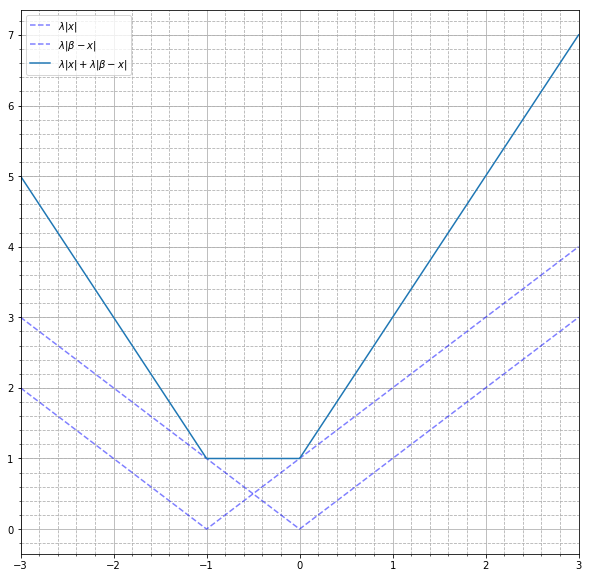

In [20]:
plt.figure(figsize=(10,10))

beta = -1
lam = 1.0
xplot = np.linspace(-3,3,1000)
yplot = lam * np.abs(beta - xplot) + lam * np.abs(xplot)
plt.plot(xplot, lam * np.abs(beta - xplot),'b--',alpha=0.5,label=r'$\lambda|x|$')
plt.plot(xplot, lam * np.abs(xplot),'b--',alpha=0.5, label=r'$\lambda|\beta - x|$')

plt.plot(xplot, yplot, label=r'$\lambda|x| +\lambda|\beta - x|$');
plt.legend()
plt.xlim([-3,3])
plt.grid(b=True, which='major');
plt.grid(b=True, which='minor', linestyle='--');
plt.minorticks_on();

For ridge regression we can similarly decompose the objective as 

$$
\begin{align*}
J(\theta^\star) &= ||X\theta^\star - y||^2 + \lambda||\theta^\star||_2^2\\
&= ||x_1\theta_1^\star + x_2\theta_2^\star+ X_r\theta_r^\star - y||^2 + \lambda (\theta_1^\star)^2+ \lambda(\theta_2^\star)^2 + \lambda ||\theta_r^\star||^2\\
&= ||x_1(\theta_1^\star +\theta_2^\star)+ X_r\theta_r^\star - y||^2 + \lambda (\theta_1^\star)^2 + \lambda(\theta_2^\star)^2 + \lambda ||\theta_r^\star||^2\\
&= (\theta_1^\star +\theta_2^\star)^2||x_1||^2 + 2(\theta_1^\star +\theta_2^\star)\cdot x_1^T(X_r\theta_r^\star - y) + ||X_r\theta_r^\star - y||^2 + \lambda (\theta_1^\star)^2 + \lambda(\theta_2^\star)^2 + \lambda ||\theta_r^\star||^2\\
&= (\theta_1^\star +\theta_2^\star)^2||x_1||^2 + 2(\theta_1^\star +\theta_2^\star)\cdot \alpha + \lambda (\theta_1^\star)^2 + \lambda(\theta_2^\star)^2 + g(\theta^\star_r)
\end{align*}
$$

Defining the constant $\beta = \theta_1^\star +\theta_2^\star$ we can write the objective as

$$
\begin{align*}
J(\theta_1^\star) &= \beta^2||x_1||^2+ \beta\alpha + \lambda(\beta-\theta^\star_1) + \lambda (\theta^\star_1)^2\\
&= \beta^2||x_1||^2+ \beta\alpha + \lambda(\beta^2-2\beta\theta^\star_1+2\theta^\star_1)^2\\
\end{align*}
$$

Since $\theta_1^\star$ minimizes this expression by definition, we know that $\theta_1^\star = \beta/2$. Thus ridge regression spreads the weight evenly between the two terms.

# Problem 5

Define the empirical least squares risk as 
$$
\begin{align*}
\hat{R}(w) &= \frac{1}{n}\sum_{i=1}^n (w^Tx_i - y_i)^2\\
        &= \frac{1}{n}(Xw - y)^T(Xw-y)
\end{align*}
$$
where $X\in \mathbf{R}^{n\times m}$ and $y\in \mathbf{R}^n$

### Problem 5.1

From the normal equations, the minimizer of $\hat{R}(w)$ is given by $\hat{w} = (X^TX)^{-1}X^Ty$. Plugging back into the objective we can find the minimum empirical risk

$$
\begin{align*}
\hat{R}(\hat{w}) &= \frac{1}{n}(X\hat{w} - y)^T(X\hat{w}-y)\\
&=\frac{1}{n}(\hat{w}^TX^TX\hat{w} - 2y^TX\hat{w} + y^Ty)\\
&=\frac{1}{n}(y^TX(X^TX)^{-1}X^TX(X^TX)^{-1}X^Ty - 2y^TX(X^TX)^{-1}X^Ty + y^Ty)\\
&=\frac{1}{n}(y^TX(X^TX)^{-1}X^Ty - 2y^TX(X^TX)^{-1}X^Ty + y^Ty)\\
&=\frac{1}{n}(-y^TX(X^TX)^{-1}X^Ty + y^Ty)\\
&=\frac{1}{n}(-y^TX\hat{w} + y^Ty)\\
\end{align*}
$$

### Problem 5.2

We can complete the square to rewrite the empirical risk in terms of its minimizer. Given a positive definite quadratic form $f(x) = x^TAx + b^Tx$ we can complete the square to get the equivalent form 
$$f(x) =(x + 0.5 A^{-1}b)^TA(x + 0.5 A^{-1}b) - \frac{1}{4}b^TA^{-1}b$$

Note that in the case of the empirical risk $A= X^TX$ and $b = -2X^Ty$

$$
\begin{align*}
\hat{R}(w) &=\frac{1}{n}\left(\hat{w}^TX^TX\hat{w} - 2y^TX\hat{w} + y^Ty\right)\\
&= \frac{1}{n}\left((w - ((X^TX)^{-1})(X^Ty))^T X^TX(w - ((X^TX)^{-1})(X^Ty)) - (X^Ty)^T(X^TX)^{-1}(X^Ty) + y^Ty\right)\\
&= \frac{1}{n}\left((w - \hat{w})^T X^TX(w - \hat{w}) - (X^Ty)^T\hat{w} + y^Ty\right)\\
&= \frac{1}{n}(w - \hat{w})^T X^TX(w - \hat{w}) + \hat{R}(\hat{w})\\
\end{align*}
$$

### Problem 5.3

Though we know $\hat{w}$ is the empirical risk minimizer based on the normal equations, it immediately follows from the completed square form in the previous part. Since $X^TX\succeq 0$ and $\hat{R}(\hat{w})$ is constant wrt $w$ then must choose $w = \hat{w}$ to achieve a value of zero for the first term which is the lowest it can be. Therefore,

$$\hat{w} = \arg \min_w \hat{R}(w)$$

### Problem 5.4

Consider the level sets of $\hat{R}(w)$ which are given by 

$$
\begin{align*}
\frac{1}{n}(w - \hat{w})^T X^TX(w - \hat{w}) + \hat{R}(\hat{w}) = c\\
\implies \frac{1}{n (c - \hat{R}(\hat{w}))}(w - \hat{w})^T X^TX(w - \hat{w}) = 1\\
\end{align*}
$$

This is the definition of an ellipse centered at $\hat{w}$

# Problem 6

The LASSO optimization problem is given by 
$$ \text{minimize}_\theta\quad \sum_{i=1}^n (\theta^T x_i - y_i)^2 + \lambda ||\theta||_1$$

Because of the $\ell_1$ penalty term, this objective is not differentiable. We can instead introduce slack variables and turn it into a constrained optimization problem with a differentiable objective function

$$
\begin{align*}
\text{minimize}_\theta\quad& \sum_{i=1}^n ((\theta^+-\theta^-)^T x_i - y_i)^2 + \lambda \mathbf{1}^T(\theta^+-\theta^-)\\
\text{subject to}\quad& \theta^+ \succeq 0\\
&\theta^-\succeq 0
\end{align*}
$$

The SGD update rules are

$$
\begin{align*}
\theta^+_{i+1} &= \theta^+_{i} - \eta\left[2\left((\theta^+ - \theta^-)^Tx_{k} - y_k\right)x_{ki} + \lambda \right]\\
\theta^-_{i+1} &= \theta^-_{i} - \eta\left[-2\left((\theta^+ - \theta^-)^Tx_{k} - y_k\right)x_{ki} - \lambda \right]
\end{align*}
$$

After the gradient step is taken we can satisfy the nonnegativity constraint by projecting each component into the nonnegative orthant with $\theta_{i+1} := \max(\theta_{i+1}, 0)$

### Problem 6.1

In [4]:
_, loss_hist = projected_sgd_lasso(x_train_feat, y_train, lambda_reg=100, alpha=0.00001)

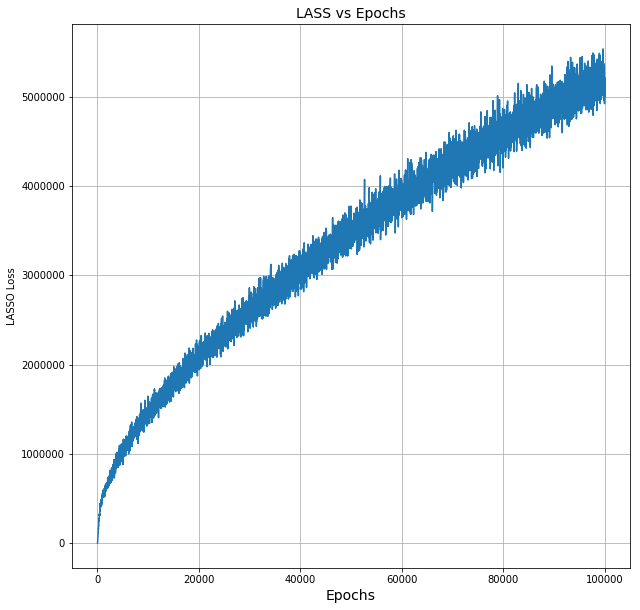

In [5]:
plt.figure(figsize=(10,10))
plt.plot(loss_hist.ravel())

plt.title('LASS vs Epochs', fontsize=14);
plt.xlabel('Epochs', fontsize=14);
plt.ylabel('LASSO Loss');
plt.grid(b=True, which='major');
plt.grid(b=True, which='minor', linestyle='--');
plt.minorticks_on()

In [8]:
_, loss_hist = projected_batch_grad_desc_lasso(x_train_feat, y_train, lambda_reg=1, alpha=0.0001)

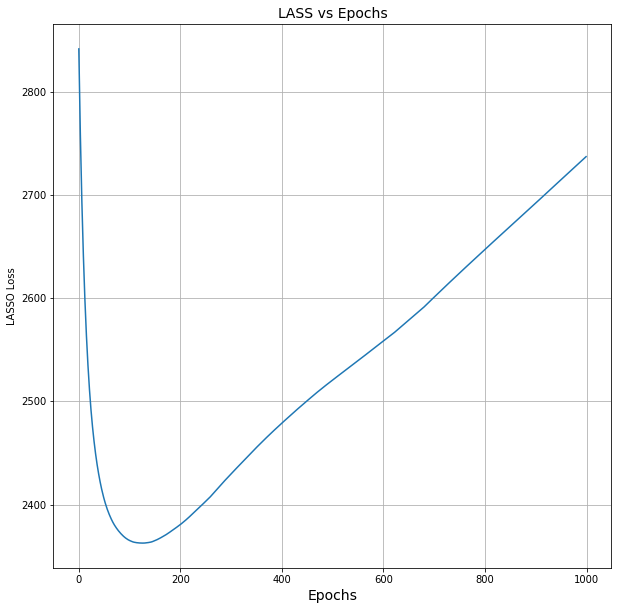

In [9]:
plt.figure(figsize=(10,10))
plt.plot(loss_hist)

plt.title('LASS vs Epochs', fontsize=14);
plt.xlabel('Epochs', fontsize=14);
plt.ylabel('LASSO Loss');
plt.grid(b=True, which='major');
plt.grid(b=True, which='minor', linestyle='--');
